In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
def PCR_thermal_cycle(filename):

    box_layout = widgets.Layout(display='flex',
                                 flex_flow='row',
                                 justify_content='center',
                                 align_items='stretch')
    
    filename_text = widgets.Text(value=filename, description="Filename")
    filename_box = widgets.Box(children=[filename_text], layout=box_layout)
    
    ambient_temp_label1 = widgets.Label('Ambient Temperature', layout=widgets.Layout(width='150px'))
    ambient_temp = widgets.FloatSlider(value = 21.67, min= 10, max=40, step=0.1, readout_format='0.1f')
    ambient_temp_label2 = widgets.Label('deg C', layout=widgets.Layout(width='70px'))
    ambient_temp_box = widgets.Box(children=[ambient_temp_label1, ambient_temp, ambient_temp_label2], layout=box_layout)
    
    heat_rate_label1 = widgets.Label('Heating Rate', layout=widgets.Layout(width='150px'))
    heat_rate = widgets.FloatSlider(value = 0.5, min=0.1, max=2, step=0.01, readout_format='0.1f')
    heat_rate_label2 = widgets.Label('deg C / s', layout=widgets.Layout(width='70px'))
    heat_rate_box = widgets.Box(children=[heat_rate_label1, heat_rate, heat_rate_label2], layout=box_layout)
    
    cool_rate_label1 = widgets.Label('Cooling Rate', layout=widgets.Layout(width='150px'))
    cool_rate = widgets.FloatSlider(value = 0.5, min=0.1, max=2, step=0.01, readout_format='0.1f')
    cool_rate_label2 = widgets.Label('deg C / s', layout=widgets.Layout(width='70px'))
    cool_rate_box = widgets.Box(children=[cool_rate_label1, cool_rate, cool_rate_label2], layout=box_layout)
    
    cycles_label1 = widgets.Label('PCR Cycles', layout=widgets.Layout(width='150px'))
    cycles = widgets.IntSlider(value=3, min=1, max=30)
    cycles_label2 = widgets.Label(' ', layout=widgets.Layout(width='70px'))
    cycles_box = widgets.Box(children=[cycles_label1, cycles, cycles_label2], layout=box_layout)
    
    initial_denaturation_label1 = widgets.Label('Initial Denaturation', layout=widgets.Layout(width='120px'))
    initial_denaturation_temp = widgets.FloatSlider(value=94, min=92, max=98, step=0.1, description='Temperature', readout_format='0.1f')
    initial_denaturation_label2 = widgets.Label('deg C', layout=widgets.Layout(width='70px'))
    initial_denaturation_dur = widgets.BoundedIntText(value=90, min=60, max=120, step=1, description='Duration')
    initial_denaturation_label3 = widgets.Label('s', layout=widgets.Layout(width='70px'))
    initial_denaturation = widgets.Box(children=[initial_denaturation_label1, initial_denaturation_temp, initial_denaturation_label2, initial_denaturation_dur, initial_denaturation_label3], layout=box_layout)
    
    denaturation_label1 = widgets.Label('Denaturation', layout=widgets.Layout(width='120px'))
    denaturation_temp = widgets.FloatSlider(value=94, min=92, max=98, step=0.1, description='Temperature', readout_format='0.1f')
    denaturation_label2 = widgets.Label('deg C', layout=widgets.Layout(width='70px'))
    denaturation_dur = widgets.BoundedIntText(value=60, min=30, max=120, step=1, description='Duration')
    denaturation_label3 = widgets.Label('s', layout=widgets.Layout(width='70px'))
    denaturation = widgets.Box(children=[denaturation_label1, denaturation_temp, denaturation_label2, denaturation_dur, denaturation_label3], layout=box_layout)

    annealing_label1 = widgets.Label('Annealing', layout=widgets.Layout(width='120px'))
    annealing_temp = widgets.FloatSlider(value=60, min=50, max=65, step=0.1, description='Temperature', readout_format='0.1f')
    annealing_label2 = widgets.Label('deg C', layout=widgets.Layout(width='70px'))
    annealing_dur = widgets.BoundedIntText(value=60, min=30, max=120, step=1, description='Duration')
    annealing_label3 = widgets.Label('s', layout=widgets.Layout(width='70px'))
    annealing = widgets.Box(children=[annealing_label1, annealing_temp, annealing_label2, annealing_dur, annealing_label3], layout=box_layout)

    extension_label1 = widgets.Label('Extension', layout=widgets.Layout(width='120px'))
    extension_temp = widgets.FloatSlider(value=72, min=68, max=72, step=0.1, description='Temperature', readout_format='0.1f')
    extension_label2 = widgets.Label('deg C', layout=widgets.Layout(width='70px'))
    extension_dur = widgets.BoundedIntText(value=90, min=30, max=180, step=1, description='Duration')
    extension_label3 = widgets.Label('s', layout=widgets.Layout(width='70px'))
    extension = widgets.Box(children=[extension_label1, extension_temp, extension_label2, extension_dur, extension_label3], layout=box_layout)

    final_extension_label1 = widgets.Label('Final Extension', layout=widgets.Layout(width='120px'))
    final_extension_dur = widgets.BoundedIntText(value=90, min=30, max=300, step=1, description='Duration')
    final_extension_label2 = widgets.Label('s', layout=widgets.Layout(width='70px'))
    final_extension = widgets.Box(children=[final_extension_label1, final_extension_dur, final_extension_label2], layout=box_layout)

    def create_setpoint_trajectory(
            filename_text,
            ambient_temp, heat_rate, cool_rate, cycles,
            initial_denaturation_temp, initial_denaturation_dur,
            denaturation_temp, denaturation_dur, 
            annealing_temp, annealing_dur,
            extension_temp, extension_dur,
            final_extension_dur):
        Ta = ambient_temp
        tp = [0]
        Tp = [Ta] 
        
        # initial denaturation 
        tp.append(tp[-1] + (initial_denaturation_temp - Tp[-1]) / heat_rate)
        Tp.append(initial_denaturation_temp)
        tp.append(tp[-1] + initial_denaturation_dur)
        Tp.append(initial_denaturation_temp)
        
        for k in range(0, cycles):
            # denaturation
            tp.append(tp[-1] + (denaturation_temp - Tp[-1]) / heat_rate)
            Tp.append(denaturation_temp)
            tp.append(tp[-1] + denaturation_dur)
            Tp.append(denaturation_temp)

            # annealing
            tp.append(tp[-1] - (annealing_temp - denaturation_temp) / cool_rate)
            Tp.append(annealing_temp)
            tp.append(tp[-1] + annealing_dur)
            Tp.append(annealing_temp)

            # extension
            tp.append(tp[-1] + (extension_temp - annealing_temp) / heat_rate)
            Tp.append(extension_temp)
            tp.append(tp[-1] + extension_dur)
            Tp.append(extension_temp)
            
        # final extension
        tp.append(tp[-1] + final_extension_dur)
        Tp.append(extension_temp)
        
        # cool down
        tp.append(tp[-1] - (Ta - Tp[-1]) / cool_rate)
        Tp.append(Ta)
        
        # plot protocol
        plt.plot(tp, Tp)
        plt.plot(tp, Tp, 'r.', ms=3)
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (deg C)')
        plt.title('PCR Temperature Program')
        plt.grid(True)
        plt.show()
        
        # save protocol to csv
        df = pd.DataFrame()
        df['tp'] = tp
        df['Tp'] = Tp
        df.to_csv(filename_text)

    display(filename_box)
    display(ambient_temp_box)
    display(heat_rate_box)
    display(cool_rate_box)
    display(cycles_box)
    display(initial_denaturation)
    display(denaturation)
    display(annealing)
    display(extension)
    display(final_extension)

    out = widgets.interactive_output(create_setpoint_trajectory, {
        'filename_text': filename_text,
        'ambient_temp' : ambient_temp,
        'heat_rate': heat_rate, 
        'cool_rate': cool_rate,
        'cycles': cycles,
        'initial_denaturation_temp' : initial_denaturation_temp,
        'initial_denaturation_dur' : initial_denaturation_dur,
        'denaturation_temp': denaturation_temp,
        'denaturation_dur': denaturation_dur,
        'annealing_temp': annealing_temp,
        'annealing_dur': annealing_dur,
        'extension_temp': extension_temp,
        'extension_dur': extension_dur,
        'final_extension_dur': final_extension_dur
        })

    display(out)



In [3]:
def get_data(file):
    
    # collect data
    df1 = pd.read_csv(file)
    df2 = pd.read_csv(file)
    tmax = max(df1['tp'].max(), df2['tp'].max())
    t = np.linspace(0, tmax, int(tmax+1))
    u1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
    u2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
    r = lambda t: np.array([u1(t), u2(t)])
    
    # graph
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    ax[0].plot(df1['tp'], df1['Tp'], 'b')
    ax[0].set(xlabel = 'Time (s)', ylabel = 'Temperature (deg C)')
    ax[0].set_title('Temperature Profile for Heaters 1 & 2')
    ax[0].grid(True)
    ax[1].plot(u1(t), u2(t))
    ax[1].set(xlabel = 'U1', ylabel = 'U1')
    ax[1].set_title('Power Profile for Heaters 1 & 2')
    ax[1].axis('square')
    return u1, u2, r

PCR Thermal Profile for Heaters 1 & 2

In [4]:
PCR_thermal_cycle('PCR/HeaterProtocol.csv')

Box(children=(Text(value='PCR/HeaterProtocol.csv', description='Filename'),), layout=Layout(align_items='stret…

Box(children=(Label(value='Ambient Temperature', layout=Layout(width='150px')), FloatSlider(value=21.67, max=4…

Box(children=(Label(value='Heating Rate', layout=Layout(width='150px')), FloatSlider(value=0.5, max=2.0, min=0…

Box(children=(Label(value='Cooling Rate', layout=Layout(width='150px')), FloatSlider(value=0.5, max=2.0, min=0…

Box(children=(Label(value='PCR Cycles', layout=Layout(width='150px')), IntSlider(value=3, max=30, min=1), Labe…

Box(children=(Label(value='Initial Denaturation', layout=Layout(width='120px')), FloatSlider(value=94.0, descr…

Box(children=(Label(value='Denaturation', layout=Layout(width='120px')), FloatSlider(value=94.0, description='…

Box(children=(Label(value='Annealing', layout=Layout(width='120px')), FloatSlider(value=60.0, description='Tem…

Box(children=(Label(value='Extension', layout=Layout(width='120px')), FloatSlider(value=72.0, description='Tem…

Box(children=(Label(value='Final Extension', layout=Layout(width='120px')), BoundedIntText(value=90, descripti…

Output()

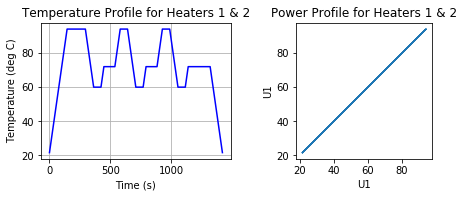

In [5]:
SP1, SP2, r = get_data('PCR/HeaterProtocol.csv')